## The effect from the QM/MM MD Distributions in Solute $\Delta S(Q)$
Vs vacuum-relaxed structures / Discrete-distance avgs from QM/MM MD.


```
Investigate S(Q) dependence on WP width/shape (and disitributions chosen from equilibrium trajectories ) 

Calculate dS(Q, t) from simulations (solute term, cross term, maybe also solvent/DV?) 

Do vacuum dynamics from GS opt. Short+Twisted minima - compare to vacuum dyn from long+eclipsed 
```

This notebook simply reads in the scattering already calculated from `ASE` trajectories using   
`Debye().debye_numba` from https://gitlab.com/asod/cmmtools/-/blob/master/test/deb_num.py


The npy files can be obtained here: https://www.dropbox.com/s/3lrmvqwhlzw7rg5/npys.zip?dl=0

`apos`: Aligned positions. Dimensions:  (#Frame, #Atom, xyz) for GS, and (#Frame, #Atom, xyz, #trajectory) for ES  
`s_:`: Scattering. Dimensions: For GS: (q, #frame). For ES: (q, #frame, #trajectory). `qvec = np.arange(0.00, 15, 0.05)`  
`ptp`: PtPOP  
`ird`: IrDimen  
`h2o` or `acn`: Whether the solvent was H2O or Acetonitrile (in the case of PtPOP). The positions and scattering is only is far only from the solutes.   
`d3` or `nod3`: For IrDimen. Indicates whether or not Grimme's D3 dispersion correction was used. When its on, the GS IrDimen conformer sampled is the short and twisted, when it's off, its the long and eclipsed.  


###### Load stuff

In [67]:
%reset -f
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False

import os, sys, matplotlib, glob
%matplotlib notebook
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
matplotlib.rc('axes.formatter', limits= (-2, 2))
plt.rcParams.update({'font.size': 14})

import numpy as np

home = os.path.expanduser('~/')
if 'jupyter-' in home:
    home = home.replace('jupyter-', '')
    sys.path.append(home + 'Dropbox/DTU2/OpenMM/omm_astools/')  # Change this to wherever you cloned CMMTools
    
def make_colors(c, colmap='viridis'):
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)
    colors = [cmap(1.*i/c) for i in range(c)]
    return colors

import nglview as nv
from ase.io import read
from cmm.xray.debye import Debye


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Making QM/MM Average structures 

To test the difference between the "$\Delta S_\mathrm{WP}$" from taking the average of the _scattering_ for each frame:  


\begin{equation}
\Delta S_\mathrm{WP}(Q) = \frac{\sum_i^{N_\mathrm{ES}} S_i(Q)}{N_\mathrm{ES}} -  \frac{\sum_i^{N_\mathrm{GS}} S_i(Q)}{N_\mathrm{GS}} 
\end{equation}

And taking the average of the _structure_ and _then_ calculating the average (effectively collapsing the WP), $\Delta S_\mathrm{\delta}(Q)$.

This test removes any possible differences arising from the vacuum-relaxed structure being different from the (average) QM/MM MD thermally sampled structure. The scattering from each frame has already been calculated and saved in .npy's. The scattering was calculated using the `get_s_from_trajs` in the cell below. 


Calculating $\Delta S_\mathrm{\delta}(Q)$ requires us to align all frames to a reference, which can just be frame #0. 

This has already been done as well, using the `align`-function in the next cell, reprinted below.,

In [68]:
def get_s_from_trajs(files, solute_atoms, qvec=np.arange(0.00, 15, 0.05)):
    deb = Debye(qvec=qvec)
    
    total_len = 0
    for f in files:
        traj = Trajectory(f)
        total_len += len(traj)
        
    S = np.zeros((len(deb.qvec), total_len))
    ct = 0
    for f in files: 
        traj = Trajectory(f)
        
        for i, atoms in enumerate(traj):
            atoms.constraints = []
            s = deb.debye_numba(atoms[:solute_atoms])
            S[:, ct] = s

            if ct % 2000 == 0:
                pct_done = 100 * ct / total_len
                fname = f.split(os.sep)[-1]
                print(f'{fname}: {pct_done:4.2f} % done')
            ct += 1

    return S


def align(atoms, ref, align_mask=None):
    '''
        atoms: ASE Atoms object to be aligned
        ref:   ASE Atoms object to align to
        align_mask: indices/bool list to align all atoms to
    '''
    if align_mask is None:
        align_mask = np.ones(len(atoms), bool)
    
    ref.constraints = None
    atoms.constraints = None
    
    a_pos = atoms.get_positions()
    r_pos = ref.get_positions()
    
    # Center everything in 0
    a_pos -= rmsd.centroid(a_pos)
    r_pos -= rmsd.centroid(r_pos)
    
    # Get rotation matrix that minimizes rmsd:
    U = rmsd.kabsch(r_pos[align_mask], a_pos[align_mask])
    
    aligned = np.dot(a_pos, U.T)
    
    a_atoms = atoms.copy()
    a_atoms.set_positions(aligned)
    
    return a_atoms
    

Read in all aligned positions, take avg, make ASE atoms objects of the avg GS and ES structure, use NGLView to show. 

(`!pip install ASE` and https://github.com/nglviewer/nglview#installation)

In [69]:

qvec = np.arange(0.00, 15, 0.05)
apos_ptp_h2o_gs = np.load('apos_ptp_h2o_gs.npy')
aligned_pos = np.load('apos_ptp_h2o_es.npy')


gs_avgpos = np.mean(apos_ptp_h2o_gs, axis=0)
gs_atoms = read('ptpop_avg_gs.xyz')
gs_atoms.set_positions(gs_avgpos)


es_avgpos = np.mean(np.mean(aligned_pos[1500:, :, :], axis=0), axis=2)
es_atoms = read('ptpop_avg_es.xyz')
es_atoms.set_positions(es_avgpos)

nv.show_ase(gs_atoms + es_atoms)

NGLWidget()

Make some 0th order model simple time bins for the ES dynamics, and calculate $\Delta S(Q)$ where the GS signal is simply the scattering from the single, discrete structure of the mean GS. 

E.g. 50 fs = 25 frames ? No convolution or anything for now..



<IPython.core.display.Javascript object>


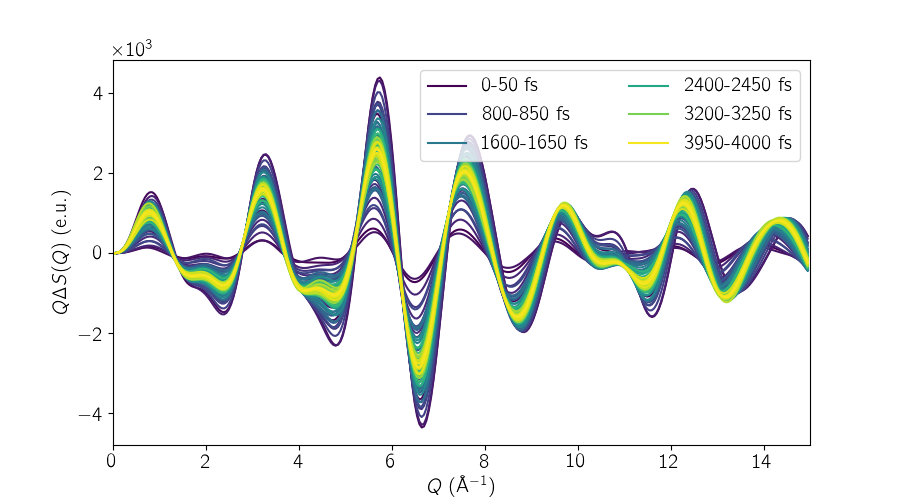

In [126]:
   
# time bins
tbins = range(0, 2001, 25)

deb = Debye(qvec=qvec)
s_avgpos_es = np.zeros((len(qvec), len(tbins) -1 ))
for t, tbin in enumerate(tbins[:-1]):
    es_avgpos = np.mean(np.mean(aligned_pos[tbin:tbins[t + 1] + 1, :, :], axis=0), axis=2)
    es_atoms.set_positions(es_avgpos)
    s = deb.debye_numba(es_atoms)
    s_avgpos_es[:, t] = s

s_avgpos_gs = deb.debye_numba(gs_atoms)
cols = make_colors(s_avgpos_es.shape[-1])

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
for e, es in enumerate(s_avgpos_es.T):
    ax.plot(qvec, qvec * (es - s_avgpos_gs), color=cols[e], label=f'{2 * tbins[e]}-{2 * tbins[e+1]} fs')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::16] + [handles[-1]], labels[::16] + [labels[-1]], loc='best', ncol=2)
ax.set_ylabel('$Q \Delta S(Q)$ (e.u.)')
ax.set_xlabel('$Q$ (Å$^{-1}$)')
ax.set_xlim([0, 15]);


### PtPOP Comparison of ES WP vs "collapsed" avgs
vs vacuum optimizations as well. 

An example of the data structure:   
`s_ptp_h2o_es` contains scattering signals from each frame of each trajectory of the PtPOP excitations in H2O.  
The dimensions are (Q, #frames, #trajectories).


For this example we simply average _all_ frames from 3000 fs and later (step 1500, due to 2 fs time steps in the simulation), and all trajectories too.


In [127]:
qvec = np.arange(0.00, 15, 0.05)

s_ptp_h2o_es = np.load('s_ptp_h2o_es.npy') #Q, time, traj
s_ptp_h2o_gs = np.load('s_ptp_h2o_gs.npy')

apos_ptp_acn_gs = np.load('apos_ptp_acn_gs.npy') 
apos_ptp_acn_es = np.load('apos_ptp_acn_es.npy') 
s_ptp_acn_es = np.load('s_ptp_acn_es.npy') #Q, time, traj
s_ptp_acn_gs = np.load('s_ptp_acn_gs.npy')

## vacuum relaxations
vac_es = read('PtP_es_vac_d3.traj@-1')
vac_gs = read('PtP_gs_vac_d3.traj@-1')

deb = Debye(qvec=qvec)
s_vac_gs = deb.debye_numba(vac_gs)
s_vac_es = deb.debye_numba(vac_es)

gs_avgpos_acn = np.mean(apos_ptp_acn_gs, axis=0)
gs_atoms_acn = vac_gs.copy()
gs_atoms_acn.set_positions(gs_avgpos_acn)
s_avgpos_gs_acn = deb.debye_numba(gs_atoms_acn)


# Lets first try a simple ON = 3000+ fs and OFF: All GS.
wp_off_h2o = np.mean(s_ptp_h2o_gs, axis=1)
av_off_h2o = s_avgpos_gs  # made in the cell above

wp_off_acn = np.mean(s_ptp_acn_gs, axis=1)
av_off_acn = s_avgpos_gs_acn


wp_on_h2o = np.mean(np.mean(s_ptp_h2o_es[:, 1500:, :], axis=2), axis=1)
wp_on_acn = np.mean(np.mean(s_ptp_acn_es[:, 1500:, :], axis=2), axis=1)

av_onpos = np.mean(np.mean(aligned_pos[1500:, :, :], axis=0), axis=2)
es_atoms = vac_gs.copy()
es_atoms.set_positions(av_onpos)
s = deb.debye_numba(es_atoms)
av_on_h2o = s


av_onpos_acn = np.mean(np.mean(apos_ptp_acn_es[1500:, :, :], axis=0), axis=2)
es_atoms_acn = vac_gs.copy()
es_atoms_acn.set_positions(av_onpos_acn)
s = deb.debye_numba(es_atoms_acn)
av_on_acn = s

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(qvec, qvec * (wp_on_h2o - wp_off_h2o), label='$\Delta S_\mathrm{WP}(Q)$')
ax.plot(qvec, qvec * (av_on_h2o - av_off_h2o), label='$\Delta S_\delta(Q)$')

ax.plot(qvec, qvec * (wp_on_acn - wp_off_acn),'C0--', label='ACN')
ax.plot(qvec, qvec * (av_on_acn - av_off_acn),'C1--', label='ACN')

ax.plot(qvec, qvec * (s_vac_es - s_vac_gs),'C3-', label='Vacuum')

ax.set_xlim([0, 15])
ax.set_ylim([-4e3, 3e3])

ax.set_ylabel('$Q \Delta S(Q)$ (e.u.)')
ax.set_xlabel('$Q$ (Å$^{-1}$)')
ax.legend(loc='best');

<IPython.core.display.Javascript object>

As expected, especially at higher Q-values, the WP signal seems smeared out compared to the $\Delta S_\delta(Q)$, showing the effects of a scattering from a finite-width WP.

The $\delta$-signal is more similar - but not identical - to the signal from scattering simulated from gas-phase relaxed geometries, i.e. what is usually used in structural fits. This shows the effect of including explicit solvent molecules and thermal averaging.


Here it would make sense to then correlate to the Pt-Pt Pinch and see the effect of WP focusing and broadening, by binning the scattering in regions selected corresponding to time periods where these effects are expressed.

## IrDimen plots

<IPython.core.display.Javascript object>


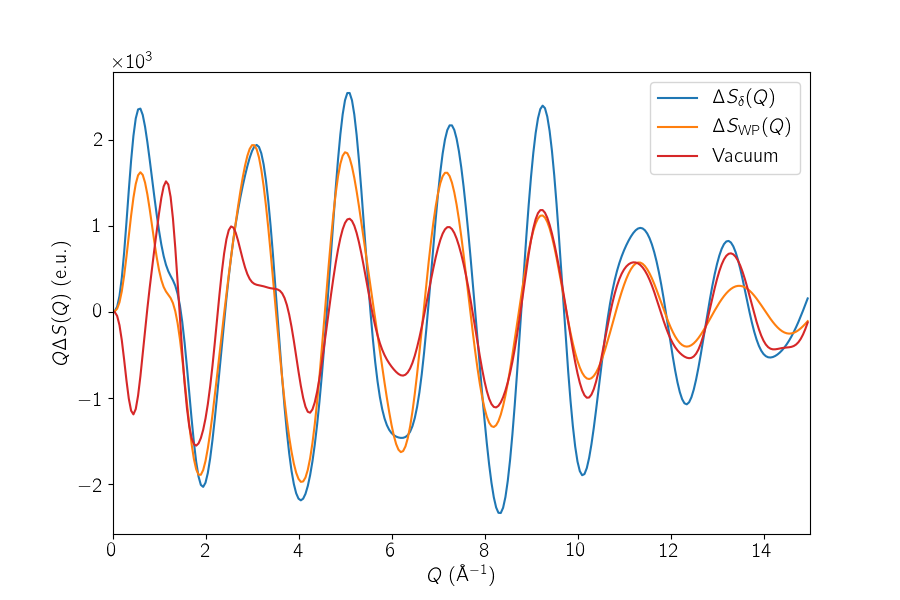

In [124]:
qvec = np.arange(0.00, 15, 0.05)

# Scattering 
s_ird_acn_es = np.load('s_ird_acn_d3_es.npy') #Q, time, traj
s_ird_acn_gs = np.load('s_ird_acn_d3_gs.npy')

# positions
apos_ird_acn_gs = np.load('apos_ird_acn_d3_gs.npy') 
apos_ird_acn_es = np.load('apos_ird_acn_d3_es.npy') 

## vacuum 
ir_vac_gs = read('IrD_twist_gs_vac_d3_verytwisted.traj@-1')
ir_vac_es = read('IrD_twist_es_vac_d3.traj@-1')

deb = Debye(qvec=qvec)
s_ir_vac_gs = deb.debye_numba(ir_vac_gs)
s_ir_vac_es = deb.debye_numba(ir_vac_es)

# make avg geom in GS, calculate scattering
gs_avgpos_acn = np.mean(apos_ird_acn_gs, axis=0)
gs_atoms_acn = ir_vac_gs.copy()
gs_atoms_acn.set_positions(gs_avgpos_acn)
s_avgpos_gs_acn = deb.debye_numba(gs_atoms_acn)

# make avg geom in ES, calculate scattering
es_avgpos_acn = np.mean(np.mean(apos_ird_acn_es[1500:, :, :], axis=0), axis=2)
es_atoms_acn = ir_vac_es.copy()
es_atoms_acn.set_positions(es_avgpos_acn)
s_avgpos_es_acn = deb.debye_numba(es_atoms_acn)

## WPs
wp_on = np.mean(np.mean(s_ird_acn_es[:, 1500:, :], axis=2), axis=1)
wp_off = np.mean(s_ird_acn_gs, axis=1)


fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(qvec, qvec * (s_avgpos_es_acn - s_avgpos_gs_acn), label='$\Delta S_\delta(Q)$')
ax.plot(qvec, qvec * (wp_on - wp_off), label='$\Delta S_\mathrm{WP}(Q)$')
ax.plot(qvec, qvec * (s_ir_vac_es - s_ir_vac_gs),'C3-', label='Vacuum')

ax.set_xlim([0, 15])
ax.set_ylabel('$Q \Delta S(Q)$ (e.u.)')
ax.set_xlabel('$Q$ (Å$^{-1}$)')
ax.legend(loc='best');

Here, due to the broader initial conditions and no real selection in creating the initial ES population, the WP and $\delta$-scattering is much more different. However, the vacuum-relaxed structure of IrDimen is also further from the explicit-solvation-averaged mean structure, giving _very_ different signals across the Q range. 

Again, choosing more intelligent time bins based on the solute ES dynamics would probably be the next step. 

To look at e.g. the avg Ir-Ir pinch, lets first find the indices of the Ir atoms:

In [121]:
print([atom.index for atom in ir_vac_gs if atom.symbol == 'Ir'])

[0, 12]


and then plot the distance of these to atoms as a function of time, averaged over all ES trajectories

<IPython.core.display.Javascript object>


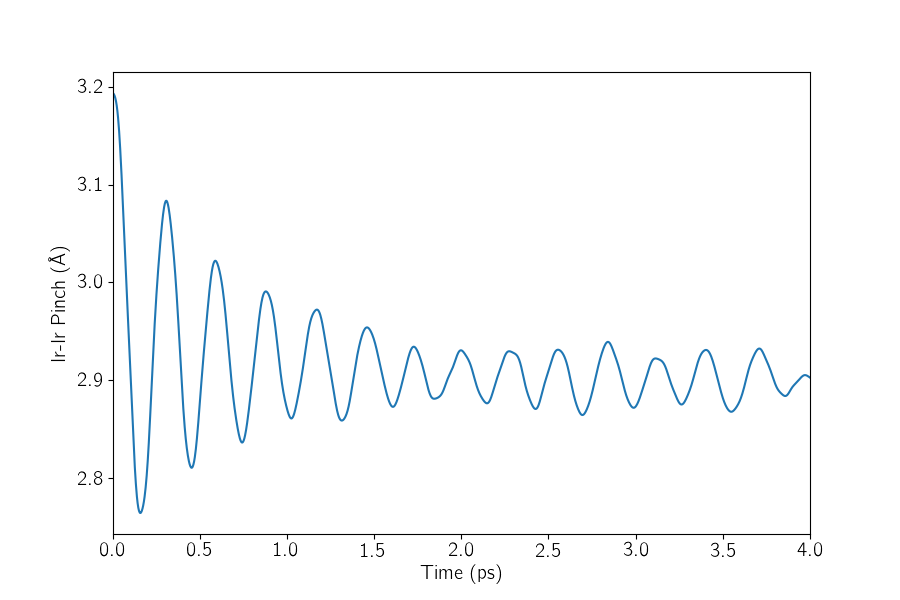

In [125]:
p_ir1 = np.mean(apos_ird_acn_es[:, 0, :, :], axis=-1)
p_ir2 = np.mean(apos_ird_acn_es[:, 12, :, :], axis=-1)
d_irir = np.linalg.norm(p_ir1 - p_ir2, axis=1)
time = np.arange(0, apos_ird_acn_es.shape[0]) * 2 # 2 fs timestep
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(time * 1e-3, d_irir)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Ir-Ir Pinch (Å)')
ax.set_xlim([0, 4]);

And so on and so forth.